In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4d5b189f-c613-b362-efd7-dbea19076167)


In [ ]:
!git clone -q https://github.com/sedol1339/voice_score

In [3]:
%cd /content/voice_score
%run utils2.ipynb
data.sample(5)

/content/voice_score


,subset,system,utterance,file,file_exists,score_mean,score_std,n_votes,votes1,votes2,votes3,votes4,votes5,fold
1098,train,sys0ca9f,utt9e0009d,sys0ca9f-utt9e0009d.wav,False,2.2500,0.4629,8,0,6,2,0,0,0
734,ood_val,sys40775,uttd28fea3,sys40775-uttd28fea3.wav,False,2.2857,0.9945,14,2,8,3,0,1,None
3176,train,sys798be,uttaf08b36,sys798be-uttaf08b36.wav,False,4.0000,0.5345,8,0,0,1,6,1,2
2334,train,sys433f2,uttfdd4e0f,sys433f2-uttfdd4e0f.wav,True,3.2500,1.0351,8,0,2,3,2,1,1
6446,val,sys9f4e0,utt26ff92b,sys9f4e0-utt26ff92b.wav,False,3.3750,0.5175,8,0,0,5,3,0,3


In [4]:
import time

device = 'cuda'
# wave2vec2_model = get_wave2vec2_model(device).eval()

In [5]:
wave2vec2_emot_model = get_wave2vec2_emot_model(device).to('cuda').eval()

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:354: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Some weights of the model checkpoint at harshit345/xlsr-wav2vec-speech-emotion-recognition were not used when initializing Wav2Vec2Model: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wa

## Источники данных

In [6]:
data_sources = {
    f'wave2vec2.{layer}': lambda file, layer=layer: file_to_wave2vec2_outputs(wave2vec2_model, file, device, output_layers=[layer])[0]
    for layer in [
          #'feature_extractor.conv_layers.3',
          #'feature_extractor.conv_layers.5',
          #'feature_extractor.conv_layers.6',
          #'transformer.layers.0',
          #'transformer.layers.1',
          #'transformer.layers.2',
          #'transformer.layers.4',
          #'transformer.layers.6',
          #'transformer.layers.8',
          #'transformer.layers.10',
    ]
}

# data_sources['wave2vec2.mix1'] = lambda file: np.concatenate(file_to_wave2vec2_outputs(wave2vec2_model, file, device,
#                           output_layers=['feature_extractor.conv_layers.6', 'transformer.layers.6']), axis=1)
# data_sources['wave2vec2.mix2'] = lambda file: np.concatenate(file_to_wave2vec2_outputs(wave2vec2_model, file, device,
#                           output_layers=['feature_extractor.conv_layers.6', 'transformer.layers.6', 'transformer.layers.10']), axis=1)
# data_sources['wave2vec2.mix3'] = lambda file: np.concatenate(file_to_wave2vec2_outputs(wave2vec2_model, file, device,
#                           output_layers=['transformer.layers.6', 'transformer.layers.10']), axis=1)
# data_sources['wave2vec2.mix4'] = lambda file: np.concatenate(file_to_wave2vec2_outputs(wave2vec2_model, file, device,
#                           output_layers=['transformer.layers.0', 'transformer.layers.1', 'transformer.layers.2']), axis=1)

def emot_model(file, layer_idx):
  with torch.no_grad():
    inputs = get_waveform(file)[None].to(device)
    results = run_wave2vec2_emot_model(wave2vec2_emot_model, inputs, transformer_layer_idx=layer_idx)
    results = results[0].cpu().detach().numpy()
  return results

data_sources.update({
    f'emot_wave2vec2.transformer.{layer}': lambda file, layer=layer: emot_model(file, layer)
    for layer in [0, 1, 2, 4, 7, 10, 15, 19, 23]
})

In [ ]:
# run_wave2vec2_emot_model(wave2vec2_emot_model, get_waveform('sys02a43-uttd08a661.wav')[None].to(device), transformer_layer_idx=23).shape

In [ ]:
# emot_model('sys02a43-uttd08a661.wav', 23).shape

## Источники данных: проверка времени работы

In [9]:
test_files = ['sys02a43-uttd08a661.wav', 'sys05205-utt61fd125.wav', 'sys19236-uttc22d6bc.wav',
              'sys35c79-utt834bb2b.wav', 'sys4017d-uttb8d822a.wav'] #all files are around 3.4 sec length - mean length of all dataset
for name, func in data_sources.items():
  start_time = time.time()
  for file in test_files:
    result = func(file)
    assert result.ndim == 2
  time_per_file = (time.time() - start_time) / len(test_files)
  print(f'[{time_per_file:g} sec/file, {time_per_file*2641:g} sec/dataset] {name}')

[0.0125899 sec/file, 33.25 sec/dataset] emot_wave2vec2.transformer.0
[0.0135058 sec/file, 35.6689 sec/dataset] emot_wave2vec2.transformer.1
[0.0138212 sec/file, 36.5017 sec/dataset] emot_wave2vec2.transformer.2
[0.0161833 sec/file, 42.74 sec/dataset] emot_wave2vec2.transformer.4
[0.0196069 sec/file, 51.7818 sec/dataset] emot_wave2vec2.transformer.7
[0.0231477 sec/file, 61.1331 sec/dataset] emot_wave2vec2.transformer.10
[0.0291067 sec/file, 76.8708 sec/dataset] emot_wave2vec2.transformer.15
[0.0339356 sec/file, 89.624 sec/dataset] emot_wave2vec2.transformer.19
[0.0386236 sec/file, 102.005 sec/dataset] emot_wave2vec2.transformer.23


## Способы обработки данных

In [ ]:
!pip install -q tensorflow_addons

In [10]:
from tensorflow.keras import layers
import tensorflow_addons as tfa

data_processing = {
    'none': lambda x: x
}

random_projection_layers = {}
def random_projection(x):
  n_features = x.shape[1]
  if not n_features in random_projection_layers:
    random_projection_layers[n_features] = layers.Dense(8192, 'tanh')
    random_projection_layers[n_features].build(input_shape=(None, n_features))
  layer = random_projection_layers[n_features]
  return layer(x).numpy()

data_processing['random_projection'] = random_projection

random_rnn_layers = {}
def random_rnn(x):
  n_features = x.shape[1]
  if not n_features in random_rnn_layers:
    random_rnn_layers[n_features] = layers.GRU(512, 'tanh', return_sequences=True, time_major=True)
    random_rnn_layers[n_features].build(input_shape=(None, None, n_features))
  layer = random_rnn_layers[n_features]
  inputs = x[:, None, :] #(timesteps, batch, feature)
  outputs = layer(inputs)[:, 0, :].numpy() #(timesteps, feature)
  return outputs

data_processing['random_rnn'] = random_rnn

random_biGRU_512_layers = {}
def random_biGRU_512(x):
  n_features = x.shape[1]
  if not n_features in random_biGRU_512_layers:
    random_biGRU_512_layers[n_features] = layers.Bidirectional(layers.GRU(512, 'tanh', return_sequences=True, time_major=True))
    random_biGRU_512_layers[n_features].build(input_shape=(None, None, n_features))
  layer = random_biGRU_512_layers[n_features]
  inputs = x[:, None, :] #(timesteps, batch, feature)
  outputs = layer(inputs)[:, 0, :].numpy() #(timesteps, feature)
  return outputs

data_processing['random_biGRU_512'] = random_biGRU_512

random_biLSTM_512_layers = {}
def random_biLSTM_512(x):
  n_features = x.shape[1]
  if not n_features in random_biLSTM_512_layers:
    random_biLSTM_512_layers[n_features] = layers.Bidirectional(layers.LSTM(512, 'tanh', return_sequences=True, time_major=True))
    random_biLSTM_512_layers[n_features].build(input_shape=(None, None, n_features))
  layer = random_biLSTM_512_layers[n_features]
  inputs = x[:, None, :] #(timesteps, batch, feature)
  outputs = layer(inputs)[:, 0, :].numpy() #(timesteps, feature)
  return outputs

data_processing['random_biLSTM_512'] = random_biLSTM_512

# random_biGRU_try2_512_layers = {}
# def random_biGRU_try2_512(x):
#   n_features = x.shape[1]
#   if not n_features in random_biGRU_try2_512_layers:
#     random_biGRU_try2_512_layers[n_features] = layers.Bidirectional(layers.GRU(512, 'tanh', return_sequences=True, time_major=True))
#     random_biGRU_try2_512_layers[n_features].build(input_shape=(None, None, n_features))
#   layer = random_biGRU_try2_512_layers[n_features]
#   inputs = x[:, None, :] #(timesteps, batch, feature)
#   outputs = layer(inputs)[:, 0, :].numpy() #(timesteps, feature)
#   return outputs

# data_processing['random_biGRU_try2_512'] = random_biGRU_try2_512

# random_biLSTM_try2_512_layers = {}
# def random_biLSTM_try2_512(x):
#   n_features = x.shape[1]
#   if not n_features in random_biLSTM_try2_512_layers:
#     random_biLSTM_try2_512_layers[n_features] = layers.Bidirectional(layers.LSTM(512, 'tanh', return_sequences=True, time_major=True))
#     random_biLSTM_try2_512_layers[n_features].build(input_shape=(None, None, n_features))
#   layer = random_biLSTM_try2_512_layers[n_features]
#   inputs = x[:, None, :] #(timesteps, batch, feature)
#   outputs = layer(inputs)[:, 0, :].numpy() #(timesteps, feature)
#   return outputs

# data_processing['random_biLSTM_try2_512'] = random_biLSTM_try2_512

random_esn_layers = {}
def random_esn(x):
  n_features = x.shape[1]
  if not n_features in random_esn_layers:
    random_esn_layers[n_features] = tfa.layers.ESN(512, return_sequences=True)
    random_esn_layers[n_features].build(input_shape=(None, None, n_features))
  layer = random_esn_layers[n_features]
  inputs = x[None, :, :] #(batch, timesteps, feature)
  outputs = layer(inputs)[0, :, :].numpy() #(timesteps, feature)
  return outputs

data_processing['random_esn'] = random_esn

## Способы обработки данных: проверка времени работы

In [11]:
for name, func in data_processing.items():
  assert func(np.zeros((10, 768))).ndim == 2
  start_time = time.time()
  for file in test_files:
    result = func(np.zeros((170, 768))) #170 frames (3.4 sec, 50 Hz), 768 features
    assert result.ndim == 2
  time_per_file = (time.time() - start_time) / len(test_files)
  print(f'[{time_per_file:g} sec/file, {time_per_file*2641:g} sec/dataset] {name}')

[0.000253773 sec/file, 0.670214 sec/dataset] none
[0.00494852 sec/file, 13.069 sec/dataset] random_projection
[0.0072824 sec/file, 19.2328 sec/dataset] random_rnn
[0.0148149 sec/file, 39.1263 sec/dataset] random_biGRU_512
[0.0157963 sec/file, 41.7181 sec/dataset] random_biLSTM_512
[0.229957 sec/file, 607.317 sec/dataset] random_esn


## Способы избавления от временной оси

In [12]:
data_reduction = {
    'last': lambda x: x[-1],
    'mean': lambda x: x.mean(axis=0),
    'mean_std': lambda x: np.concatenate([x.mean(axis=0), x.std(axis=0)]),
    'max': lambda x: x.max(axis=0),
}

In [13]:
reduction_ops_for_processing = {
    'none': {'mean', 'mean_std', 'max'},
    'random_projection': {'mean', 'mean_std', 'max'},
    'random_rnn': {'last', 'mean', 'mean_std', 'max'},
    'random_esn': {'last', 'mean', 'mean_std', 'max'},
    'random_biGRU_512': {'mean'},
    'random_biLSTM_512': {'mean'},
    # 'random_biGRU_try2_512': {'mean'},
    # 'random_biLSTM_try2_512': {'mean'},
}

cannot_pregenerate = ['wave2vec2.feature_extractor.conv_layers.3']

## Создание/обновление датасетов

In [ ]:
!gcloud auth login

In [15]:
saved_datasets = !gsutil ls gs://oleg-zyablov/misc/VoiceMOS/datasets
saved_datasets = set([x.split('/')[-1] for x in saved_datasets[1:]])

def get_filename(src_name, proc_name, reduction_name):
  return f'{src_name}__{proc_name}__{reduction_name}.npz'

# filenames = set()
# for src_name, src_func in data_sources.items():
#   for proc_name, proc_func in data_processing.items():
#     for reduction_name, reduction_func in data_reduction.items():
#       filenames.add(get_filename(src_name, proc_name, reduction_name))
# datasets_to_save = filenames.difference([x for x in saved_datasets])
# print(f'{len(saved_datasets)} datasets already saved, {len(datasets_to_save)} to save')

In [16]:
train_and_val_files = data[data.subset.isin(['train', 'val']) & data.file_exists].file

for source_name, source_fn in tqdm(data_sources.items()):
  if not source_name in cannot_pregenerate:
    pregenerated = {}
    for file in tqdm(train_and_val_files, leave=False, desc=f'pregenerating source {source_name}'):
      pregenerated[file] = source_fn(file)
  else:
    pregenerated = None
  for proc_name, proc_fn in tqdm(data_processing.items(), leave=False, desc=f'source = {source_name}'):
    reduction_names = reduction_ops_for_processing[proc_name]
    results = {reduction_name: [] for reduction_name in reduction_names}
    for file in tqdm(train_and_val_files, leave=False, desc=f'proc = {proc_name}'):
      x = pregenerated[file] if not source_name in cannot_pregenerate else source_fn(file)
      x = proc_fn(x)
      for reduction_name in reduction_names:
        reduction_op = data_reduction[reduction_name]
        result = reduction_op(x)
        results[reduction_name].append(result)
    for reduction_name in reduction_names:
      filename = get_filename(source_name, proc_name, reduction_name)
      array = np.array(results[reduction_name])
      assert len(array) == len(train_and_val_files)
      np.savez_compressed(filename, array)
      !gsutil -q cp {filename} gs://oleg-zyablov/misc/VoiceMOS/datasets/{filename}
      !rm {filename}

  0%|          | 0/9 [00:00<?, ?it/s]

pregenerating source emot_wave2vec2.transformer.0:   0%|          | 0/2641 [00:00<?, ?it/s]

source = emot_wave2vec2.transformer.0:   0%|          | 0/6 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biGRU_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biLSTM_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2641 [00:00<?, ?it/s]

pregenerating source emot_wave2vec2.transformer.1:   0%|          | 0/2641 [00:00<?, ?it/s]

source = emot_wave2vec2.transformer.1:   0%|          | 0/6 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biGRU_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biLSTM_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2641 [00:00<?, ?it/s]

pregenerating source emot_wave2vec2.transformer.2:   0%|          | 0/2641 [00:00<?, ?it/s]

source = emot_wave2vec2.transformer.2:   0%|          | 0/6 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biGRU_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biLSTM_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2641 [00:00<?, ?it/s]

pregenerating source emot_wave2vec2.transformer.4:   0%|          | 0/2641 [00:00<?, ?it/s]

source = emot_wave2vec2.transformer.4:   0%|          | 0/6 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biGRU_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biLSTM_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2641 [00:00<?, ?it/s]

pregenerating source emot_wave2vec2.transformer.7:   0%|          | 0/2641 [00:00<?, ?it/s]

source = emot_wave2vec2.transformer.7:   0%|          | 0/6 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biGRU_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biLSTM_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2641 [00:00<?, ?it/s]

pregenerating source emot_wave2vec2.transformer.10:   0%|          | 0/2641 [00:00<?, ?it/s]

source = emot_wave2vec2.transformer.10:   0%|          | 0/6 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biGRU_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biLSTM_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2641 [00:00<?, ?it/s]

pregenerating source emot_wave2vec2.transformer.15:   0%|          | 0/2641 [00:00<?, ?it/s]

source = emot_wave2vec2.transformer.15:   0%|          | 0/6 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biGRU_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biLSTM_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2641 [00:00<?, ?it/s]

pregenerating source emot_wave2vec2.transformer.19:   0%|          | 0/2641 [00:00<?, ?it/s]

source = emot_wave2vec2.transformer.19:   0%|          | 0/6 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biGRU_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biLSTM_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2641 [00:00<?, ?it/s]

pregenerating source emot_wave2vec2.transformer.23:   0%|          | 0/2641 [00:00<?, ?it/s]

source = emot_wave2vec2.transformer.23:   0%|          | 0/6 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biGRU_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_biLSTM_512:   0%|          | 0/2641 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2641 [00:00<?, ?it/s]

## Тест загрузки данных

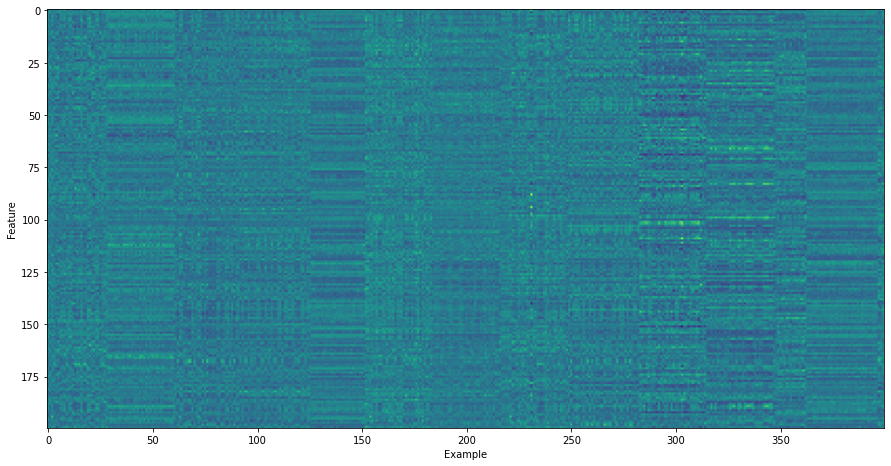

In [ ]:
filename = 'wave2vec2.feature_extractor.conv_layers.5__none__mean.npz'
!wget -q https://storage.googleapis.com/oleg-zyablov/misc/VoiceMOS/datasets/{filename}
arr = np.load(filename)['arr_0']

from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(15, 15))
plt.imshow(StandardScaler().fit_transform(arr)[:400, :200].T)
plt.xlabel('Example')
plt.ylabel('Feature')
plt.show()